In [1]:
import pandas as pd 
import numpy as np 
import uncertainties
from uncertainties import ufloat_fromstr
from uncertainties import unumpy as unp
import glob
import matplotlib.pyplot as plt
from scipy import stats
from scipy . optimize import curve_fit
from scipy . interpolate import interp1d
from scipy import optimize
import re
import scipy.integrate as inte

#--- plot parameters --- 
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30

## Data import

In [2]:
# --- data import --- 

# --- importing copper raw data --- 
data_main_Cu = glob.glob('data/Temp+Force_Cu_*.csv')
print(np.shape(data_main_Cu))

# --- importing Aluminium raw data --- 
data_main_Al = glob.glob('data/Temp+Force_Al_*.csv')
print(np.shape(data_main_Al))

# --- importing calibration data --- 
data_main_calibration = glob.glob('data/CalibrationPoint*.csv')
print(np.shape(data_main_calibration))

# ---- importing mass calibration data --- 
mass_calibration_data = pd.read_csv('data/CalibrationMassData.csv', sep = ';', delimiter = None,)

# --- Source Weights and Mass numbers --- 

Al_source_mass = unp.uarray(11.22, 0.005)
Cu_source_mass = unp.uarray(25.78, 0.005)

N_Al = Al_source_mass/26.981538 # values taken from Commission on Isotopic Abundances and Atomic Weights (CIAAW), International Union of Pure and Applied Chemistry (IUPAC) 
N_Cu = Cu_source_mass/63.546 

print(N_Al, N_Cu)

(10,)
(10,)
(4,)
0.41584+/-0.00019 0.40569+/-0.00008


In [3]:
data_main_Cu

['data\\Temp+Force_Cu_-100C.csv',
 'data\\Temp+Force_Cu_-120C.csv',
 'data\\Temp+Force_Cu_-130C.csv',
 'data\\Temp+Force_Cu_-140C.csv',
 'data\\Temp+Force_Cu_-150C.csv',
 'data\\Temp+Force_Cu_-20C.csv',
 'data\\Temp+Force_Cu_-40C.csv',
 'data\\Temp+Force_Cu_-60C.csv',
 'data\\Temp+Force_Cu_-80C.csv',
 'data\\Temp+Force_Cu_10C.csv']

In [4]:
# --- Test Import --- 

test_import = pd.read_csv(data_main_Cu[0], sep = ';', delimiter = None,)

test_import

Time (secs)  Force sensor voltage (volts)  \
0            0.0                         0.562   
1            1.0                         0.563   
2            2.0                         0.564   
3            3.0                         0.563   
4            4.0                         0.563   
..           ...                           ...   
236        236.0                         0.519   
237        237.0                         0.519   
238        238.0                         0.519   
239        239.0                         0.519   
240        240.0                         0.519   

     Force sensor voltage error (volts)  Diode circuit voltage (volts)  \
0                               0.00481                          0.776   
1                               0.00173                          0.775   
2                               0.00168                          0.774   
3                               0.00131                          0.774   
4                               0.00134                          0.774   
..                                  ...                            ...   
236                             0.00166                          1.000   
237                             0.00152                          1.000   
238                             0.00152                          1.000   
239                             0.00157                          1.000   
240                             0.00151                          1.000   

     Diode circuit voltage error (volts)  
0                               0.001290  
1                               0.001340  
2                               0.001480  
3                               0.001770  
4                               0.001430  
..                                   ...  
236                             0.001040  
237                             0.001230  
238                             0.001130  
239                             0.000979  
240                             0.000968  

[241 rows x 5 columns]

In [5]:
# --- defining an import function --- 

def import_raw(file): 
    t = []; force_V = []; Diode_V = [] # - defining empty arrays. 

    temp = int(re.search(r'\-?\d+', file).group(0)) + 273.15
    file = pd.read_csv(file, sep = ';', delimiter = None,)

    t = file['Time (secs)']
    force_V = unp.uarray(file['Force sensor voltage (volts)'], file['Force sensor voltage error (volts)'])
    Diode_V = unp.uarray(file['Diode circuit voltage (volts)'], file['Diode circuit voltage error (volts)'])


    return np.array(t), force_V, Diode_V, temp 

def temp(filename):
    return int(re.search(r'\-?\d+', filename).group(0)) + 273.15

## Mass calibration function. 

In [6]:
def lin_func(x, m, c):
    return m*x + c #equation of a line y = mx + c

In [7]:
# --- array definition --- 

mass = unp.uarray(mass_calibration_data['Mass (Kg)'], mass_calibration_data['Mass Error (Kg)'])
voltage = unp.uarray(mass_calibration_data['Force Sensor Voltage (Volts)'], mass_calibration_data['Force Sensor Voltage Error (Volts)'])

<ipython-input-8-174a608f0712>:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('images/mass_calibration.png', bbox = 'tight')


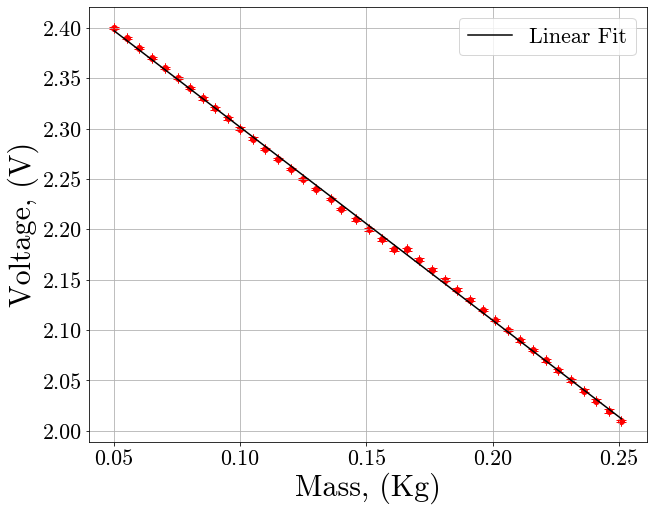

In [8]:
# --- data definition --- 

x = unp.nominal_values(mass)
xerr = unp.std_devs(mass)

y = unp.nominal_values(voltage)
yerr = unp.std_devs(voltage)

x_fit = np.linspace(0, x.max(), 10)

# --- fitting data for graph --- 

popt1, pcov1 = curve_fit(lin_func, x, y, sigma = (xerr))
fit_data = lin_func(x, popt1[0], popt1[1])

CM = popt1[0]
MM = popt1[1]

plt.figure(figsize=(10, 8))

plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = xerr, yerr = yerr, capsize= 5, ls='none', color = 'red')
plt.plot(x, fit_data, 'black', label = 'Linear Fit')


plt.grid()
plt.xlabel('Mass, (Kg)')
plt.ylabel('Voltage, (V)')
plt.legend()

plt.savefig('images/mass_calibration.png', bbox = 'tight')

In [9]:
print('The equation of the above fit is: y = ', "{:.3f}".format(popt1[0]), 'x +', "{:.3f}".format(popt1[1]))



# --- finding y-intercept --- 


x = 0 
y = (popt1[0]*x) + popt1[1]
print('y-intercept of the line:', "{:.3f}".format(y))

Mass_Slope_Uncertainty = np.sqrt(pcov1[1][1])
Mass_Constant_Uncertainty = np.sqrt(pcov1[0][0])

mass_equation_uncertainty = unp.uarray([CM, MM], [Mass_Constant_Uncertainty, Mass_Slope_Uncertainty])

# --- uncertainties on the slopes --- 

print('Uncertainty on the slope was found to be: ' "{:.3f}".format(np.sqrt(pcov1[1][1])))
print('Uncertainty on the constant was found to be: ' "{:.3f}".format(Mass_Constant_Uncertainty))

print(CM, MM)

The equation of the above fit is: y =  -1.916 x + 2.493
y-intercept of the line: 2.493
Uncertainty on the slope was found to be: 0.001
Uncertainty on the constant was found to be: 0.007
-1.9158069730495513 2.492915446743638


From calibration data then the mass based on calbration will be given as follows, 

$$ M = \frac{V - c}{m} $$
$$m = −0.52192066 V + 1.30114822$$ 

In [10]:
def mass_func(V): 
    return -0.52197325*V + 1.30123518

# def mass_func(V):
#     return (-1/mass_equation_uncertainty[0])*V + mass_equation_uncertainty[1]/mass_equation_uncertainty[0]*-1

$$ C_v(T_1) \ = \ \frac{L_v \Delta m}{n_{\text{moles}} (T_1 - 77)}$$ 

Aluminum block of has a weight of $11.22 \pm 0.005$ g and an atomic mass of $26.981539$ u which means it contains $0.4158399$ moles 

In [11]:
def heat_capacity_exp(dM, T, L, n):# 1 - kJ/mol 2 - Number of moles 
    return (L*dM)/(n*(T - 77))

## Temperture Calibration, 

$$  T=aV^2+bV + c  $$ 

In [12]:
def import_calibration(file): 
    temp = []; Diode_V = [] # - defining empty arrays. 

    file = pd.read_csv(file, sep = ';', delimiter = None,)

    temp = unp.uarray(file['Temperature (K)'], file['Temp Error (K)'])
    Diode_V = unp.uarray(file['Diode Circuit Voltage (Volts)'], file['Diode Volt Error (Volts)'])

    return temp, Diode_V

def temp_fit(V, a, b, c):
    return a*V**2 + b*V + c

<ipython-input-13-ab9e58517a23>:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('images/temp_calibration.png', bbox = 'tight')


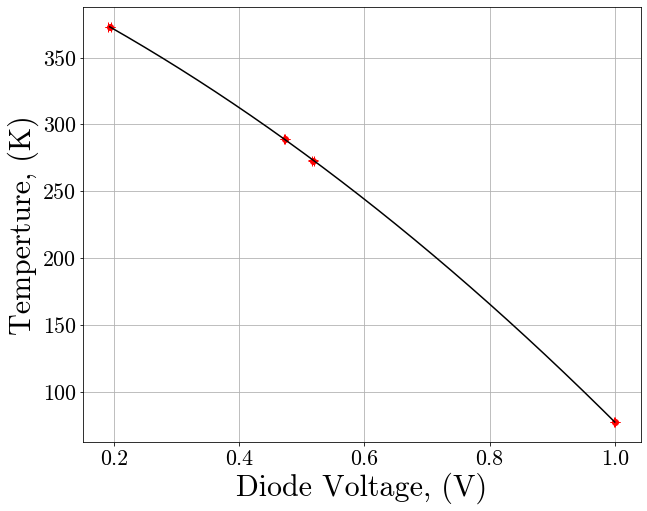

In [13]:
temp_c = []; Diode_C = [] 

for i in range(0, len(data_main_calibration)):
    data_c = import_calibration(data_main_calibration[i])
    temp_c.append(data_c[0])
    Diode_C.append(data_c[1])

# --- data definition --- 

y = np.reshape(unp.nominal_values(temp_c), (4))
yerr = np.reshape(unp.std_devs(temp_c), (4))

x = np.reshape(unp.nominal_values(Diode_C), (4))
xerr = np.reshape(unp.std_devs(Diode_C), (4))

x_fit = np.linspace(0, x.max(), 10)

# --- fitting data for graph --- 

popt2, pcov2 = curve_fit(temp_fit, x, y)

AT = popt2[0]
BT = popt2[1]
CT = popt2[2]

x_fit = np.linspace(x.min(), x.max(), 1000)
fit_data = temp_fit(x_fit, AT, BT, CT)

plt.figure(figsize=(10, 8))

plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = xerr, yerr = yerr, capsize= 5, ls='none', color = 'red')
plt.plot(x_fit, fit_data, 'black')


plt.grid()
plt.ylabel('Temperture, (K)')
plt.xlabel('Diode Voltage, (V)')
# plt.legend()

plt.savefig('images/temp_calibration.png', bbox = 'tight')

In [14]:
# --- finding y-intercept --- 

x = 0 
y = (popt1[0]*x) + popt1[1]
print('y-intercept of the line:', "{:.3f}".format(y))

# --- uncertainties on the slopes --- 

print('Uncertainty on the slope was found to be: ' "{:.3f}".format(np.sqrt(pcov1[1][1])))

y-intercept of the line: 2.493
Uncertainty on the slope was found to be: 0.001


From calibration data then the temperture based on calbration will be given as follows, 

$$T = −373.67216185 V_d + 457.69276882$$ 

In [15]:
def temp_func(V): 
    return AT*V**2 + BT*V + CT

## Plotting for Al 

252.0 968.971095814875
<ipython-input-101-38d63ee4de3f>:34: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-101-38d63ee4de3f>:42: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-101-38d63ee4de3f>:43: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (xmax - 50,  y

Text(0, 0.5, 'Mass (g)')

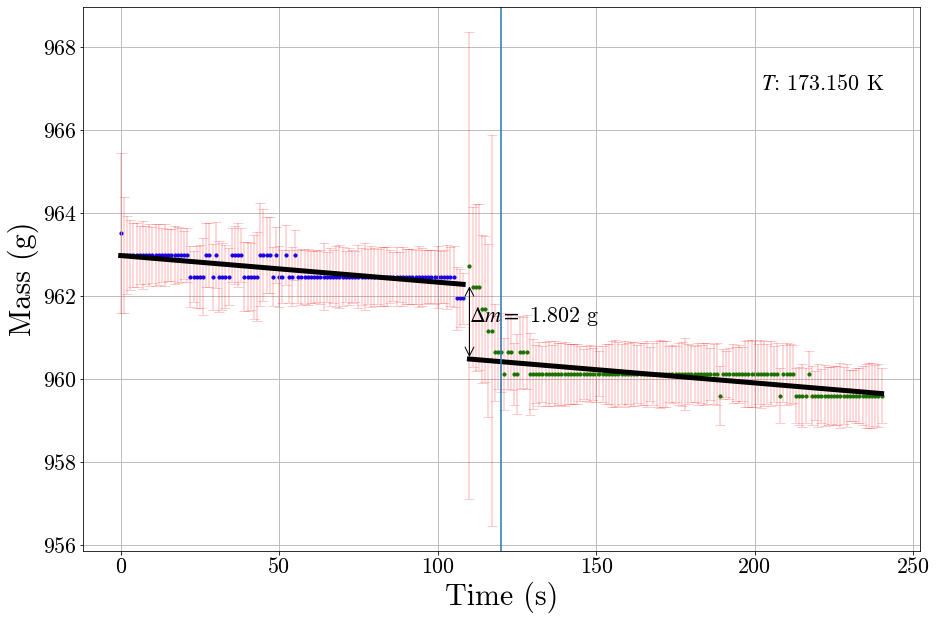

In [101]:
### --- Al at 15C --- 

data = import_raw(data_main_Al[0])
mass = mass_func(data[1])

# print(np.diff(unp.nominal_values(mass)*1000))

# --- Splitting both sets --- 

split1 = np.argmax(np.diff(unp.nominal_values(mass*1000)))
split2 = split1 + 1  

# --- Split One --- 

plt.scatter(data[0][0:split1], (unp.nominal_values(mass)*1000 )[0:split1], s = 10, color = 'blue')
plt.errorbar(data[0][0:split1], (unp.nominal_values(mass)*1000 )[0:split1], xerr = None, yerr = (unp.std_devs(mass)*1000)[0:split1], capsize= 5, ls='none', color = 'red', alpha = .2)

popt1, pcov1 = curve_fit(lin_func, data[0][0:split1], (unp.nominal_values(mass)*1000 )[0:split1], sigma = ((unp.std_devs(mass)*1000)[0:split1]))
fit_data1 = lin_func(data[0][0:split1], popt1[0], popt1[1])

plt.plot(data[0][0:split1], fit_data1, 'black', label = 'Linear Fit', linewidth = 5.0)


# --- Split Two --- 

plt.scatter(data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 11.22)[split2:len(mass)], s = 10, color = 'green')
plt.errorbar(data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 11.22)[split2:len(mass)], xerr = None, yerr = (unp.std_devs(mass)*1000)[split2:len(mass)], capsize= 5, ls='none', color = 'red', alpha = .2)

popt2, pcov2 = curve_fit(lin_func, data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 11.22)[split2:len(mass)], sigma = ((unp.std_devs(mass)*1000)[split2:len(mass)]))
fit_data2 = lin_func(data[0][split2:len(mass)], popt2[0], popt2[1])

plt.plot(data[0][split2:len(mass)], fit_data2, 'black', linewidth = 5.0)

plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))

deltam = fit_data1[-1] -  fit_data2[0]

xmin, xmax, ymin, ymax = plt.axis()

print(xmax, ymax)

plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (xmax - 50,  ymax - 2))

plt.axvline(x = 120)

plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Mass (g)')

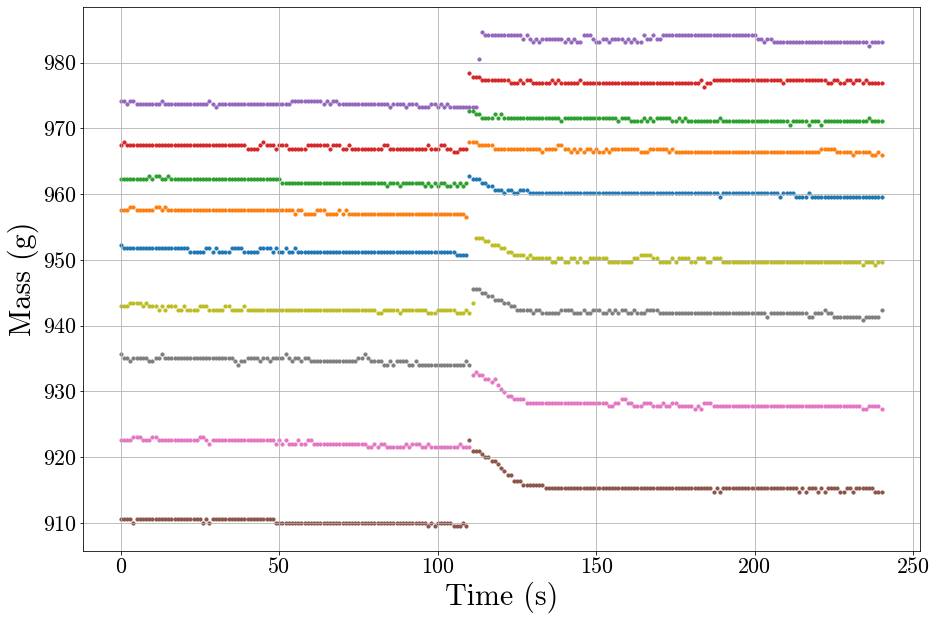

In [17]:
for i in range(0, 9): 

    data = import_raw(data_main_Al[i])

    mass = mass_func(data[1])

    plt.scatter(data[0], unp.nominal_values(mass)*1000 - 11.22, s = 10, label = '')
    # plt.errorbar(data[0], unp.nominal_values(mass)*1000 - 11.22, xerr = None, yerr = unp.std_devs(mass)*1000, capsize= 5, ls='none', color = 'red', alpha = .5)

    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Mass (g)')

### Temperture against mass 

In [18]:
for i in range(0, 10): 
    
    data = import_raw(data_main_Al[i])
    mass = mass_func(unp.nominal_values(data[1]))
    temp = temp_func(unp.nominal_values(data[2]))

    # plt.scatter(temp, mass)
    # plt.show()

## Plotting Heat Capacities

### Dulong–Petit law,

$$ C_v = 3Nk_b $$ 

### Einstein's Model, 

$$ C_v = 3Nk_B \left( \frac{\theta_E}{T}\right)^2 \frac{e^{\theta_E/T}}{(e^{\theta_E/T} - 1)^2} $$ 

In [19]:
def heat_capacity_einstein(T, et):
    N_atoms = 6.0221409e+23; k_b = 1.3807e-23
    coeff = 3*N_atoms*k_b 
    term_1 = (et/T)**2 
    term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2

    return coeff*term_1*term_2

### Debeye Model 

\begin{align} C_{V}=\dfrac{\partial U}{\partial T}=9Nk_{B}(\dfrac{T}{T_{D}})^{3}\int_{0}^{x_{D}}dx\dfrac{x^{4}e^{x}}{(e^{x}-1)^{2}} \end{align}


At low tempertures $T << T_D$, only long wavelength acoustic modes are thermally excited. hese are just the modes that can be treated as elastic continuum with macroscopic elastic constants. The energy of those short wavelength modes are too high to be populated significantly at low temperatures. We may approximate $x_d = T_d/T$ to infinity and make use of the standard integral, 
\begin{align} \int_{0}^{\infty}dx\dfrac{x^{3}}{e^{x}-1}=\dfrac{\pi^{4}}{15} \end{align}

$$ C_v = \frac{12R \pi^4}{5} \left( \frac{T}{T_D} \right)^3 $$ 

Which then can be written as for low tems, 

\begin{align} C_{V}=\dfrac{12\pi^{4}Nk_{B}T^{3}}{5T_{D}^{3}}\cong324Nk_{B}\dfrac{T^{3}}{T_{D}^{3}} \end{align} 

In [21]:
def heat_capacity_Debeye(T,D):
    g = []; a = []
    for i in T:
        a = inte.quad((x**4)*(np.exp(x))/(np.exp(x)-1)**2, 0, D/i)
        g.append(a[0])
    return 9*8.3145*(T/D)**3*np.array(g)


962.18+/-0.32
960.31+/-0.32
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy =

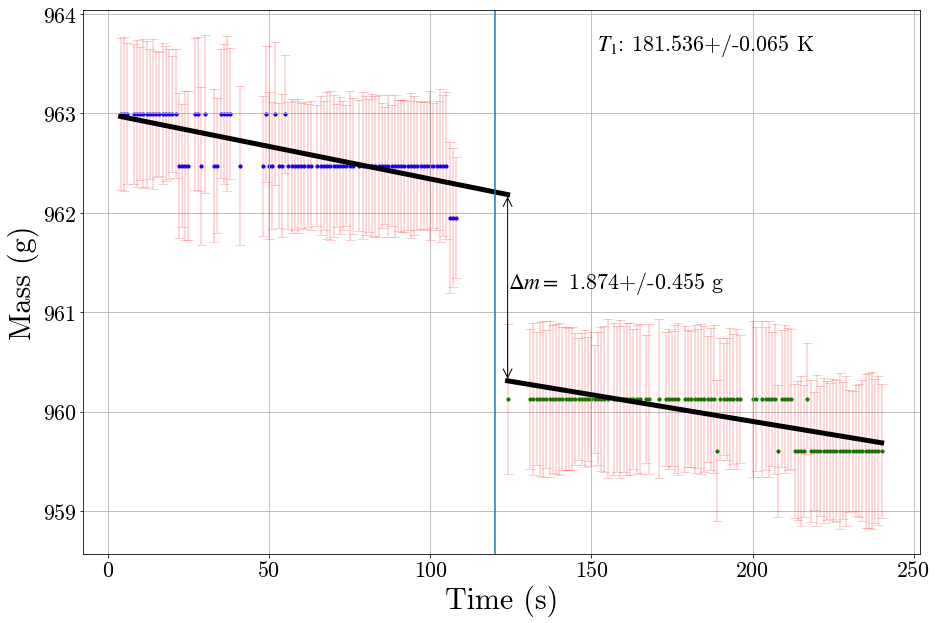

967.99+/-0.26
967.03+/-0.26
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy =

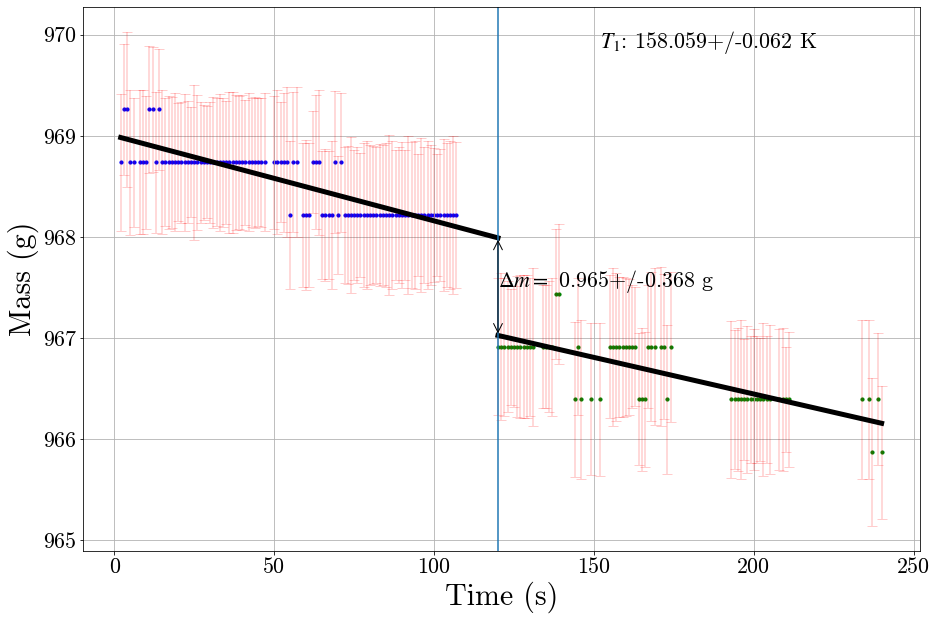

972.46+/-0.34
971.75+/-0.34
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy =

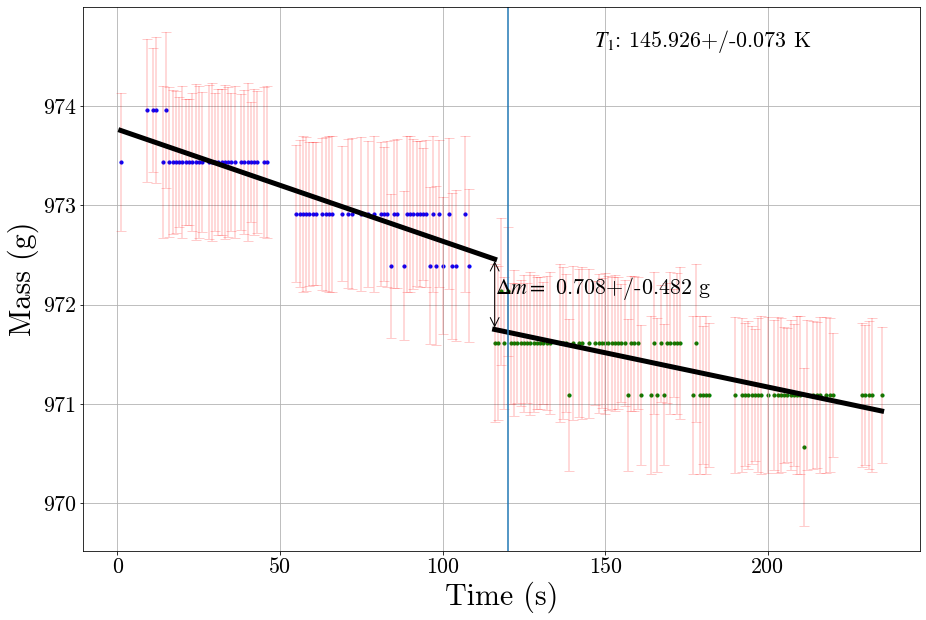

978.03+/-0.35
976.99+/-0.35
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy =

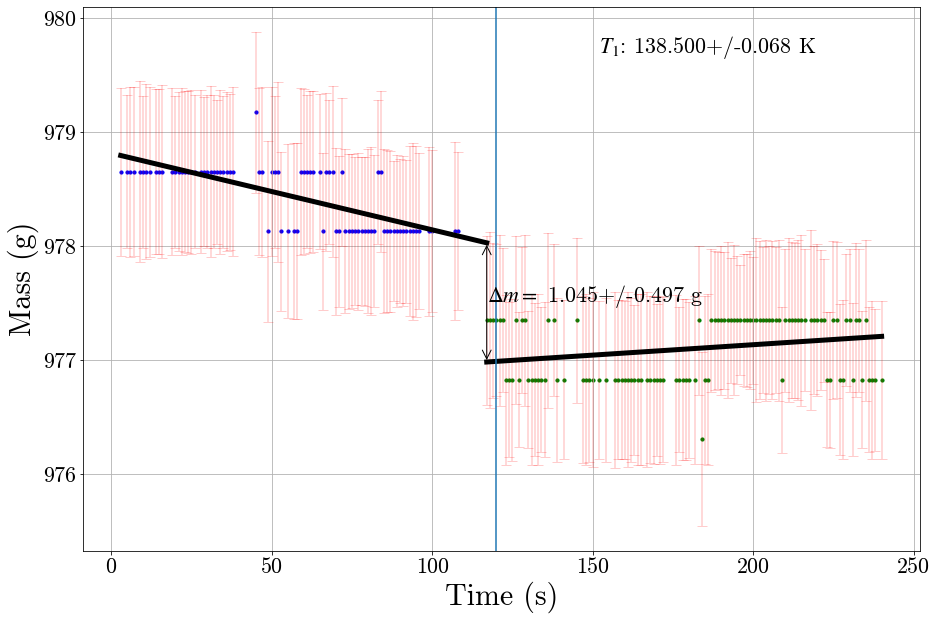

984.7+/-0.5
983.8+/-0.5
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xm

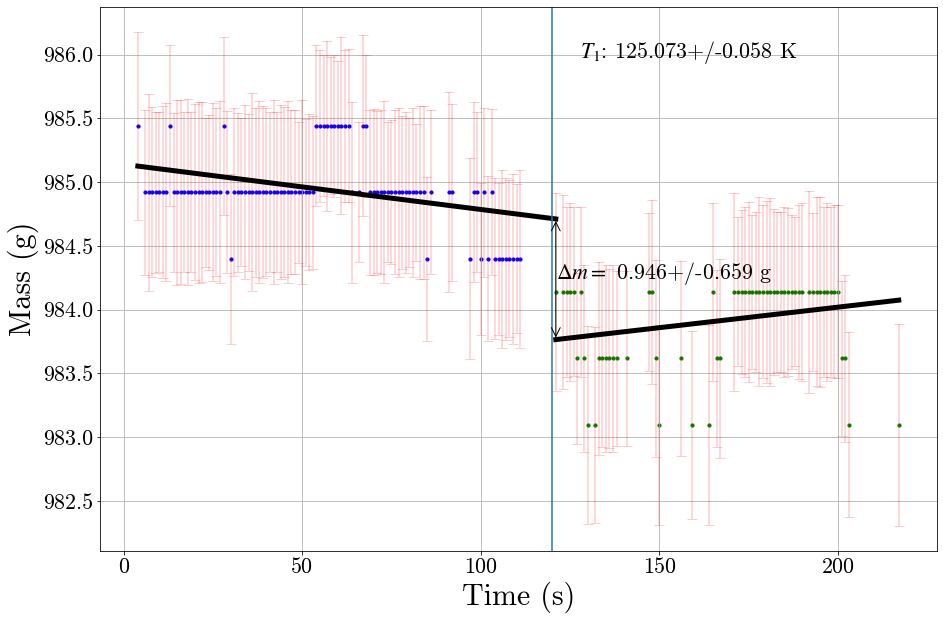

920.87+/-0.33
915.48+/-0.33
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy =

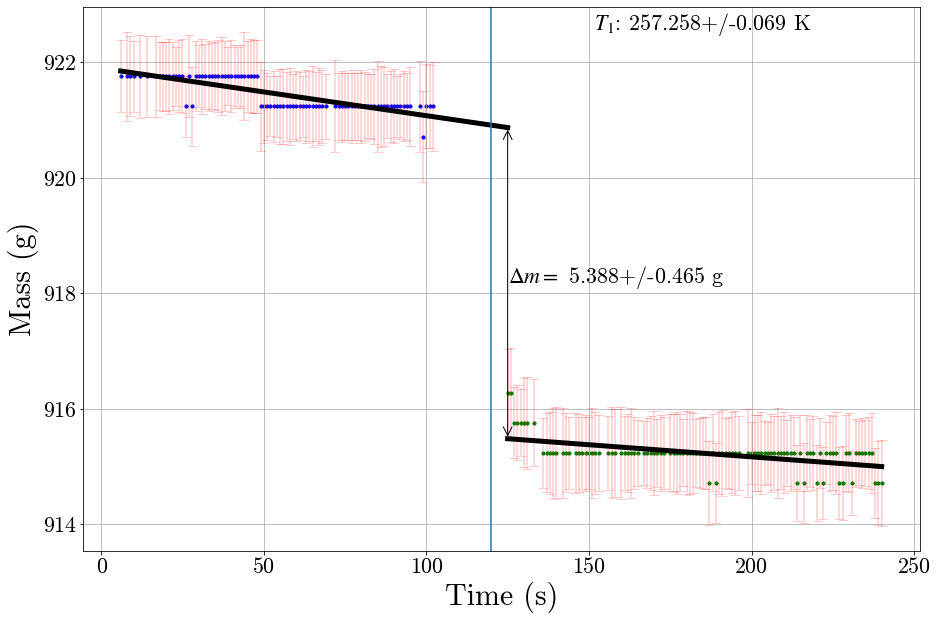

932.6+/-0.5
928.4+/-0.5
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xm

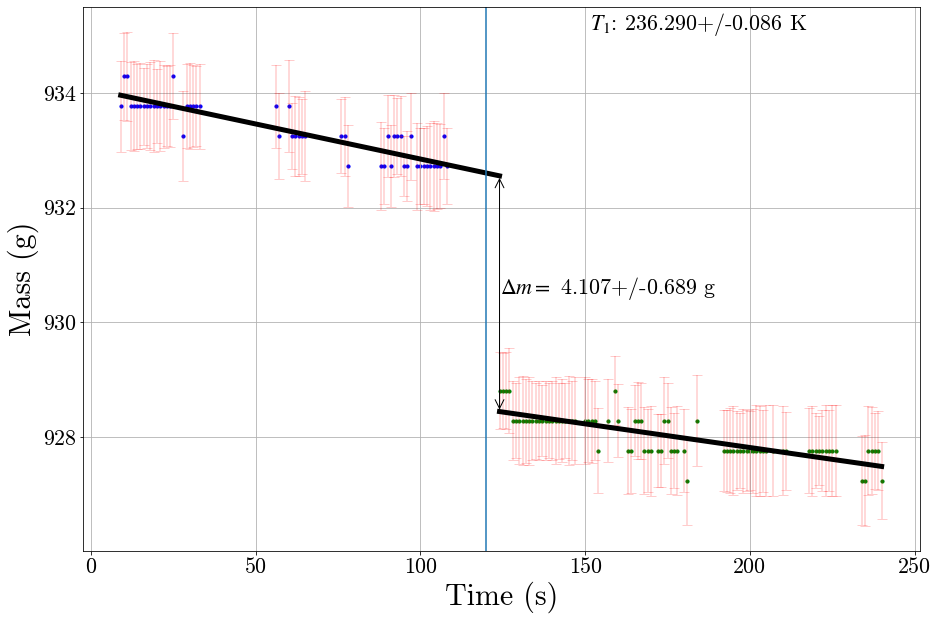

945.1+/-0.6
942.2+/-0.6
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xm

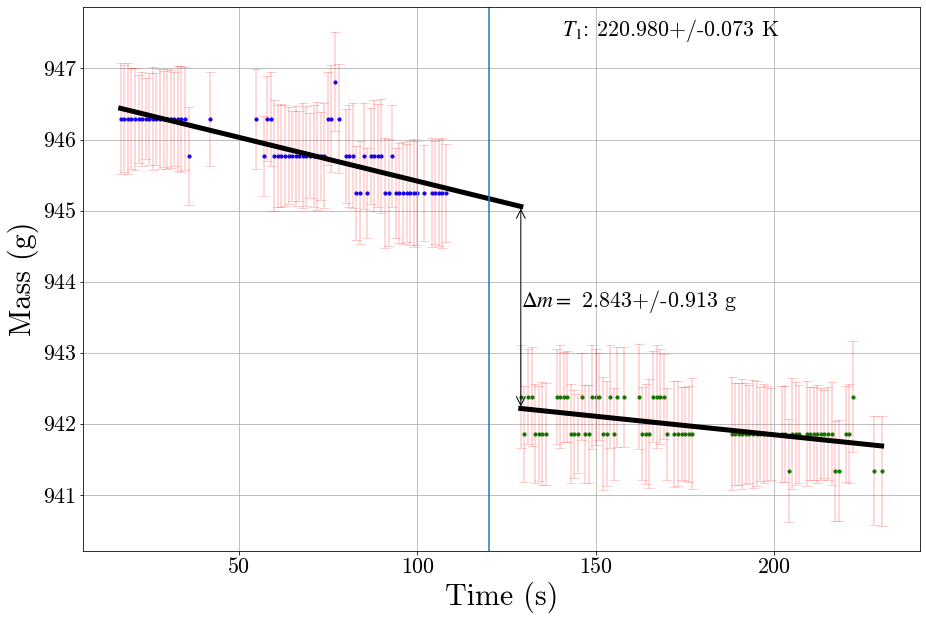

953.3+/-0.4
950.3+/-0.4
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xm

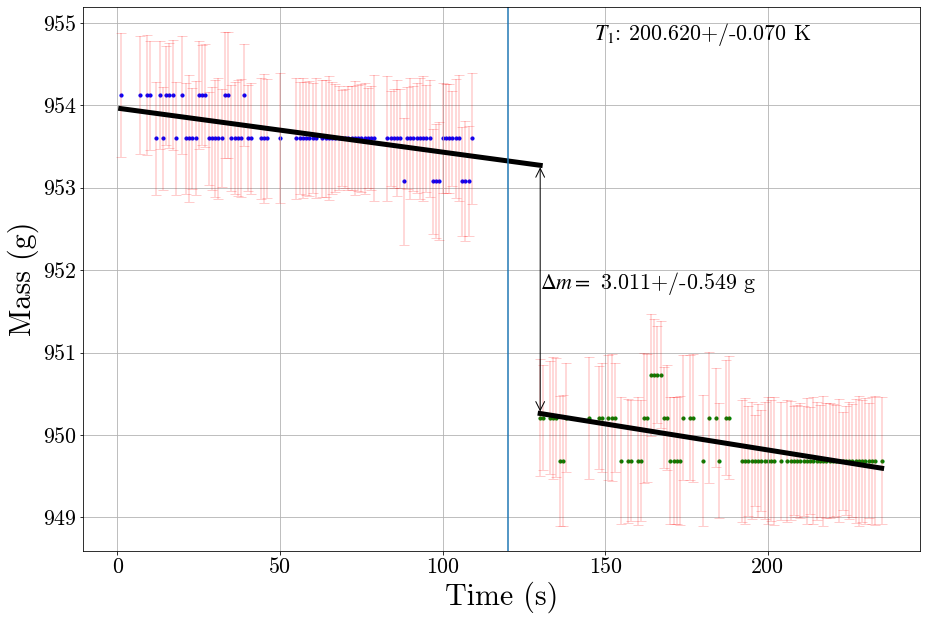

998.3+/-0.8
990.6+/-0.8
<ipython-input-102-f0b3fc9db1f9>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-102-f0b3fc9db1f9>:79: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-102-f0b3fc9db1f9>:80: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xm

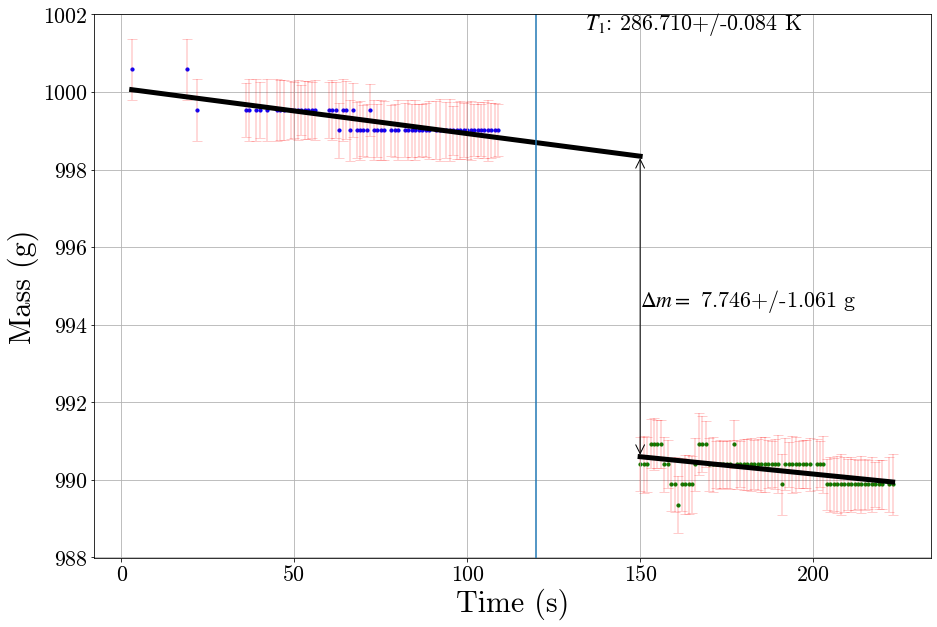

In [102]:
al_Cv_exp = []; al_Cv_ein = []; temp_a = [] ; m = []; et = 240

for i in range(0, 10):
    data = import_raw(data_main_Al[i])
    mass = mass_func(data[1])*1000
#     print(mass)
    temp = temp_func(data[2])
    time = data[0]

    temp = temp[unp.std_devs(mass) < 0.8]
    time = time[unp.std_devs(mass) < 0.8]
    mass = mass[unp.std_devs(mass) < 0.8]

    # print(temp)

    # --- Splitting both sets --- 

    split1 = np.argmax(np.diff(unp.nominal_values(mass)))
    split2 = split1 + 1  

    # --- Starting the Plots --- 
    # plt.figure(figsize=(10, 8))

    # --- Split One --- 
    plt.scatter(time[0:split1], (unp.nominal_values(mass) )[0:split1], s = 10, color = 'blue')
    plt.errorbar(time[0:split1], (unp.nominal_values(mass))[0:split1], xerr = None, yerr = (unp.std_devs(mass))[0:split1], capsize= 5, ls='none', color = 'red', alpha = .2)

    extension = time[split2:len(mass)][0] - time[0:split1].max()
    time_1_vf = np.linspace(time[0:split1].min(), time[0:split1].max() + extension, 100)

    popt1, pcov1 = curve_fit(lin_func, time[0:split1], (unp.nominal_values(mass))[0:split1], sigma = ((unp.std_devs(mass))[0:split1]))
    slope1_uc = np.sqrt(pcov1[1][1])
    constant1_uc = np.sqrt(pcov1[0][0])

    SLOPE1 = unp.uarray(popt1[0], slope1_uc)
    CONSTANT1 = unp.uarray(popt1[1], 0) # constant1_uc

    fit_data1 = lin_func(time_1_vf, popt1[0], popt1[1])

    point1 = SLOPE1*time_1_vf[-1] + CONSTANT1; print(point1)

    plt.plot(time_1_vf, fit_data1, 'black', label = 'Linear Fit', linewidth = 5.0)


    # --- Split Two --- 

    plt.scatter(time[split2:len(mass)], (unp.nominal_values(mass) - 11.22)[split2:len(mass)], s = 10, color = 'green')
    plt.errorbar(time[split2:len(mass)], (unp.nominal_values(mass) - 11.22)[split2:len(mass)], xerr = None, yerr = (unp.std_devs(mass))[split2:len(mass)], capsize= 5, ls='none', color = 'red', alpha = .2)

    popt2, pcov2 = curve_fit(lin_func, time[split2:len(mass)], (unp.nominal_values(mass) - 11.22)[split2:len(mass)], sigma = ((unp.std_devs(mass))[split2:len(mass)]))

    slope2_uc = np.sqrt(pcov1[1][1])
    constant2_uc = np.sqrt(pcov1[0][0])

    fit_data2 = lin_func(time[split2:len(mass)], popt2[0], popt2[1])

    SLOPE2 = unp.uarray(popt2[0], slope2_uc)
    CONSTANT2 = unp.uarray(popt2[1], 0) # constant2_uc

    point2 = SLOPE2*time[split2] + CONSTANT2; print(point2)

    plt.plot(time[split2:len(mass)], fit_data2, 'black', linewidth = 5.0)

    plt.annotate(s='', xy = (time[split2:len(mass)][0], fit_data2[0]), xytext=(time[split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))

    # --- Experimental Calculations 

    temp = temp[0:split1].mean()
    temp_a = np.append(temp_a, temp)

    deltam = point1 - point2
    m.append(deltam)
    al_Cv_exp.append(heat_capacity_exp(deltam, temp, 197.5, N_Al))
    al_Cv_ein.append(heat_capacity_einstein(data[3], et))

    
    xmin, xmax, ymin, ymax = plt.axis()

    plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split2],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
    plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax - 0.40))
    # plt.axvline(x = 120)

    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Mass (g)')

    plt.axvline(x = 120)

    plt.savefig('Images/Al/AL_Mass_Vs_Time(%sK).png' % '{:.0f}'.format(data[3]), bbox = 'tight')
    plt.show()

In [79]:
# --- Writing results for .csv --- 
Al_dataframe = data_frame(temp_a, m, al_Cv_exp)

print(temp_a)

print(Al_dataframe.to_latex(index=False))

[181.53641437851803+/-0.06468150027468086
 158.058678995017+/-0.06190075196084687
 145.92570658982007+/-0.07322651230740572
 138.50039317693307+/-0.06838363191568361
 125.07310330614065+/-0.058003693714833486
 257.25840947488234+/-0.06911003233096613
 236.28957957936484+/-0.08638793314090056
 220.98001607827408+/-0.07286106074584303
 200.61967355667676+/-0.06997438241237655
 286.70959013005785+/-0.0838691325039491]
\begin{tabular}{rrrrrr}
\toprule
 Temp (K) &  UC Temp (K) &  Mass (g) &  UC Mass (g) &  Cv (J/Mol) &  UC Cv (J/Mol) \\
\midrule
    182.0 &        0.065 &       1.9 &        0.455 &         9.0 &          2.066 \\
    158.0 &        0.062 &       1.0 &        0.368 &         6.0 &          2.156 \\
    146.0 &        0.073 &       0.7 &        0.482 &         5.0 &          3.322 \\
    139.0 &        0.068 &       1.0 &        0.497 &         8.0 &          3.839 \\
    125.0 &        0.058 &       0.9 &        0.659 &         9.0 &          6.512 \\
    257.0 &        0.06

Einstein Temperture is then, 653.7813467211724 +/- 35.06432355198701
Debeye Temperture is then, 801.3413841841634 +/- 48.2029716102302
<ipython-input-19-f497a243da20>:4: RuntimeWarning: divide by zero encountered in true_divide
  term_1 = (et/T)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: divide by zero encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: overflow encountered in exp
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: overflow encountered in square
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: invalid value encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-21-14b0d0b484dc>:9: RuntimeWarning: divide by zero encountered in double_scalars
  a  = inte.quad(integrand, 0, D/i)
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: overflow encountered in double

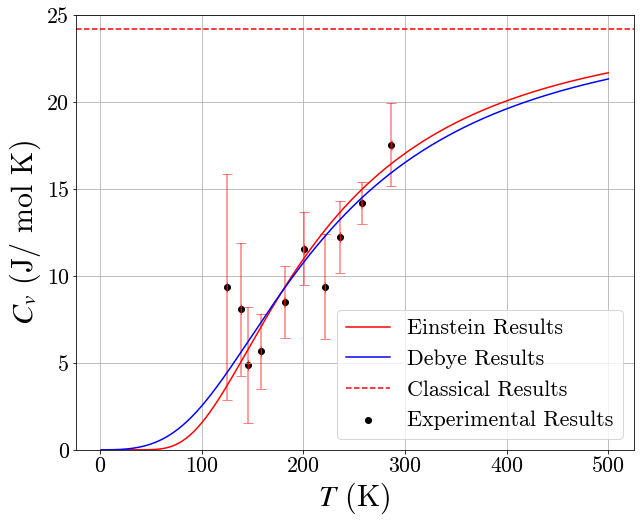

In [80]:
# --- Einstein Results --- 
Temp_s = np.linspace(unp.nominal_values(temp_a).min(), unp.nominal_values(temp_a).max(), 1000)
Temp_s = np.linspace(0, 500, 1000)

# -- model fit 

popt1, pcov1 = curve_fit(heat_capacity_einstein, unp.nominal_values(temp_a), unp.nominal_values(al_Cv_exp))

print("Einstein Temperture is then,", popt1[0], '+/-', np.sqrt(pcov1[0][0]))

# --- Debeye Model --- 

popt2, pcov2 = curve_fit(debye, unp.nominal_values(temp_a), unp.nominal_values(al_Cv_exp))

print("Debeye Temperture is then,", popt2[0] - 100, '+/-', np.sqrt(pcov2[0][0]))

# --- Scatter Plots --- 

plt.figure(figsize=(10, 8))

plt.scatter(unp.nominal_values(temp_a), unp.nominal_values(al_Cv_exp), color = 'black', label = 'Experimental Results')
plt.errorbar(unp.nominal_values(temp_a), unp.nominal_values(al_Cv_exp), xerr = unp.std_devs(temp_a), yerr = unp.std_devs(al_Cv_exp), capsize= 5, ls='none', color = 'red', alpha = .5)

plt.plot(Temp_s, heat_capacity_einstein(Temp_s,  popt1[0]), color = 'red', label = 'Einstein Results')
plt.plot(Temp_s, debye(Temp_s,  popt2[0]), color = 'blue', label = 'Debye Results')

plt.axhline(y = 24.2, color = 'red', linestyle='--', label = 'Classical Results')
plt.grid()
plt.ylabel("$C_v$ (J/ mol K)")
plt.ylim(0, 25)
plt.xlabel("$T$ (K)")
plt.legend()

plt.savefig('Images/Al_Experimental_Plot.png', bbox = 'tight')

## Theortical Predictions 

<ipython-input-19-f497a243da20>:4: RuntimeWarning: divide by zero encountered in true_divide
  term_1 = (et/T)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: divide by zero encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: overflow encountered in square
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: invalid value encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-21-14b0d0b484dc>:9: RuntimeWarning: divide by zero encountered in double_scalars
  a  = inte.quad(integrand, 0, D/i)
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: overflow encountered in double_scalars
  return (x**4)*(np.exp(x))/(np.exp(x)-1)**2
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: overflow encountered in exp
  return (x**4)*(np.exp(x))/(np.exp(x)-1)**2
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: invalid value encountered in doub

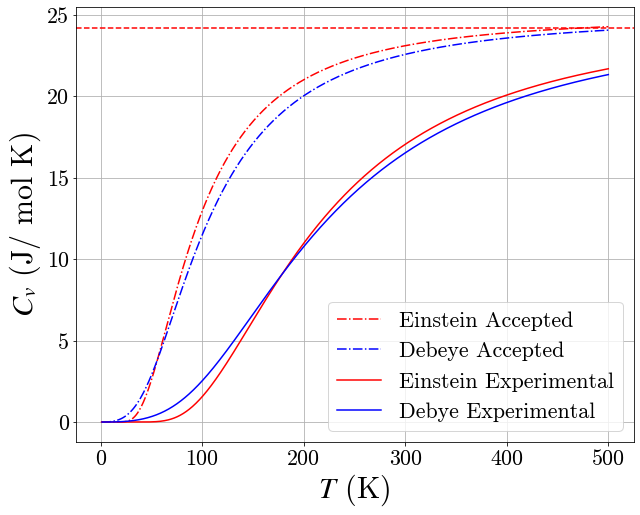

In [81]:
# --- Generating Data for Theortical Models from Derived Equations --- 

# Temp_s = np.linspace(unp.nominal_values(temp_a).min(), unp.nominal_values(temp_a).max(), 1000)
Temp_s = np.linspace(0, 500, 1000)

th_ein = heat_capacity_einstein(Temp_s, 290)
th_Deb = debye(Temp_s, 430)

# --- Plotting --- 

plt.figure(figsize=(10, 8))

plt.plot(Temp_s, th_ein, color = 'red', label = 'Einstein Accepted', linestyle='dashdot')
plt.plot(Temp_s, th_Deb, color = 'blue', label = 'Debeye Accepted', linestyle='dashdot')
plt.plot(Temp_s, heat_capacity_einstein(Temp_s,  popt1[0]), color = 'red', label = 'Einstein Experimental')
plt.plot(Temp_s, debye(Temp_s,  popt2[0]), color = 'blue', label = 'Debye Experimental')
plt.axhline(y = 24.2, color = 'red', linestyle='--')

plt.grid()

plt.ylabel("$C_v$ (J/ mol K)")
plt.xlabel("$T$ (K)")

plt.legend()

plt.savefig('Images/Al_Comparison_Plot.png', bbox = 'tight')

# Copper Calculations 

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

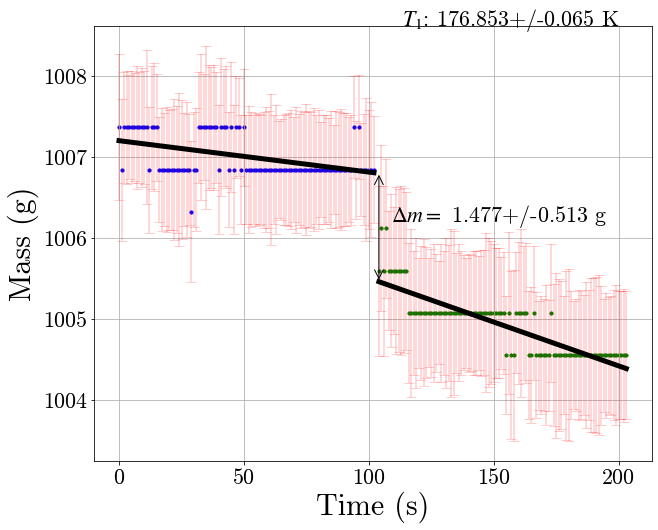

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

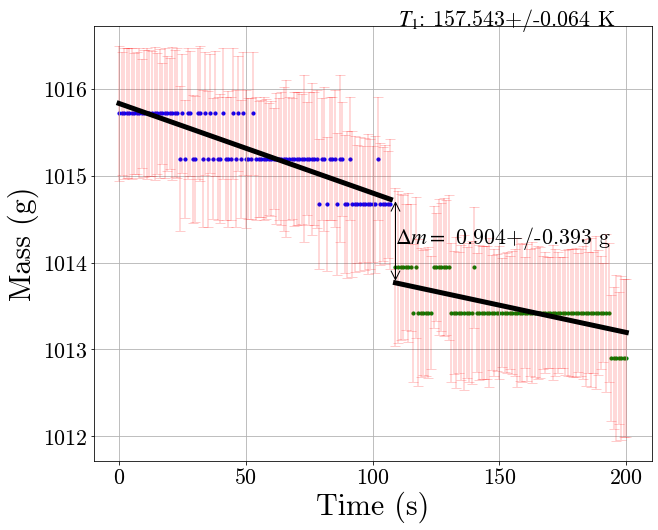

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

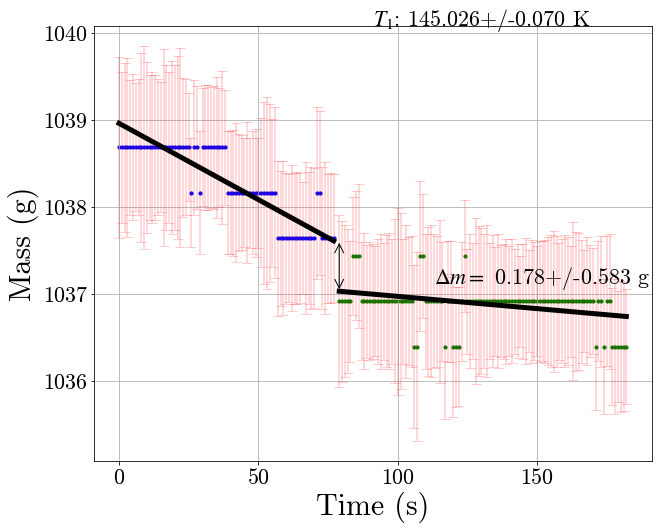

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

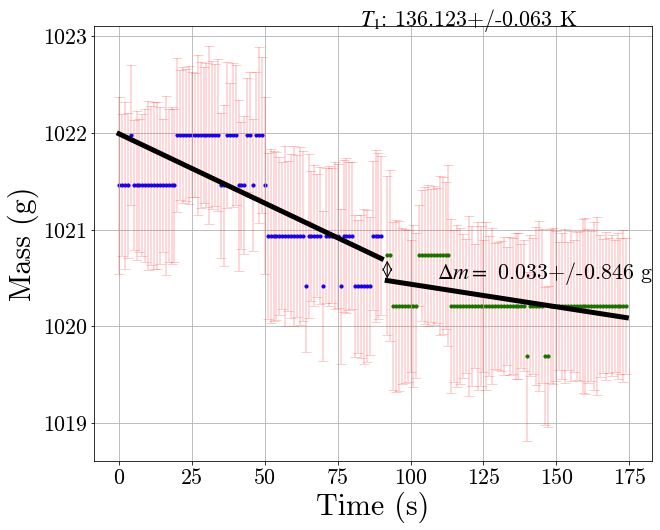

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

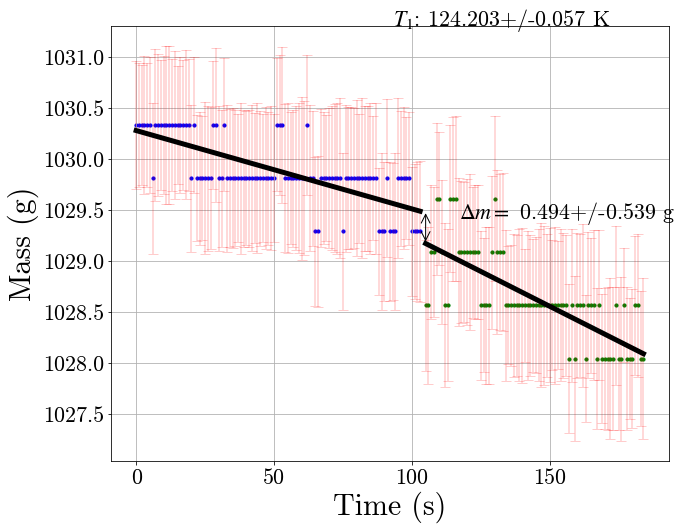

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

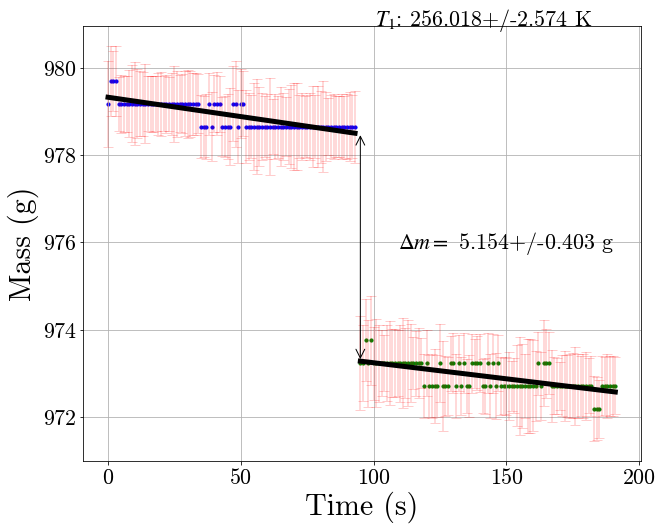

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

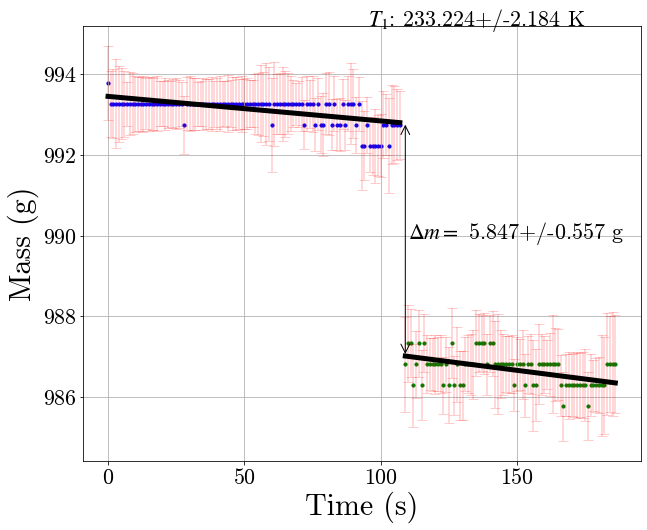

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

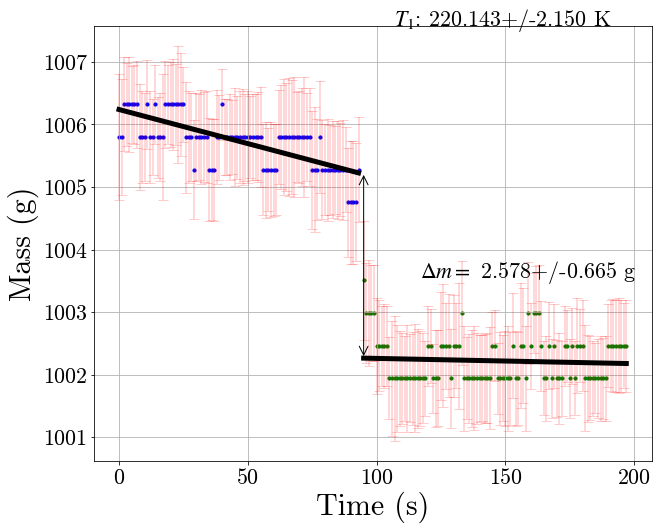

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

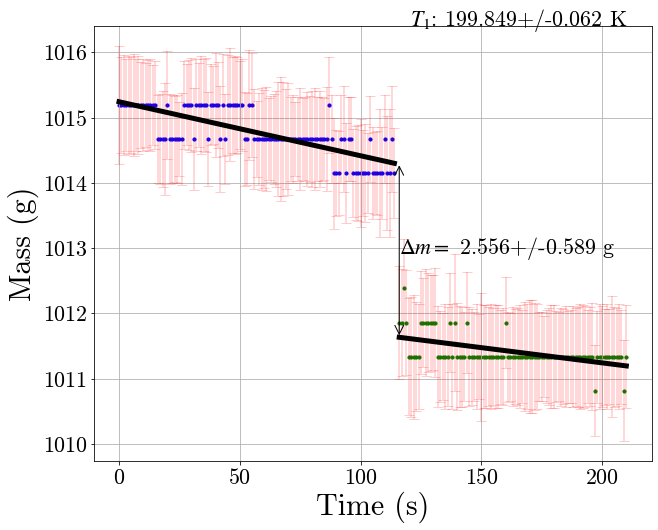

<ipython-input-82-10917a003830>:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-82-10917a003830>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
<ipython-input-82-10917a003830>:87: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))
<ip

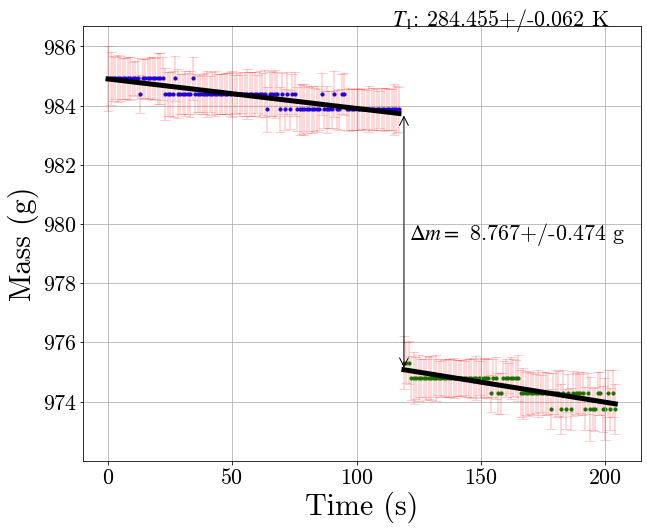

In [82]:
Cu_Cv_exp = []; Cu_Cv_ein = []; temp_a = [] ; m = [] # --- defining empty arrays 

for i in range(0, 10): 

    data = import_raw(data_main_Cu[i])
    mass = mass_func(data[1])*1000

    cutoff = unp.std_devs(mass).mean() + unp.std_devs(mass).std() # --- Cutoff point for error size. 

    temp = temp_func(data[2])
    time = data[0]

    # --- Removing those points from the data set. 

    temp = temp[unp.std_devs(mass) < cutoff]  
    time = time[unp.std_devs(mass) < cutoff]
    mass = mass[unp.std_devs(mass) < cutoff]

    # --- Splitting both sets --- 

    split1 = np.argmax(np.diff(unp.nominal_values(mass))) # --- splitting data set based on step difference 
    split2 = split1 + 1  

    # --- Starting the Plots --- 
    
    plt.figure(figsize=(10, 8))

    # --- Split One --- 

    plt.scatter(data[0][0:split1], (unp.nominal_values(mass))[0:split1], s = 10, color = 'blue')
    plt.errorbar(data[0][0:split1], (unp.nominal_values(mass))[0:split1], xerr = None, yerr = (unp.std_devs(mass))[0:split1], capsize= 5, ls='none', color = 'red', alpha = .2)

    extension = time[split2:len(mass)][0] - time[0:split1].max()
    time_1_vf = np.linspace(time[0:split1].min(), time[0:split1].max() + extension, 100)

    popt1, pcov1 = curve_fit(lin_func, data[0][0:split1], (unp.nominal_values(mass))[0:split1], sigma = ((unp.std_devs(mass))[0:split1]))
    fit_data1 = lin_func(data[0][0:split1], popt1[0], popt1[1])

    slope1_uc = np.sqrt(pcov1[1][1])
    constant1_uc = np.sqrt(pcov1[0][0])#

    SLOPE1 = unp.uarray(popt1[0], slope1_uc)
    CONSTANT1 = unp.uarray(popt1[1], 0) # constant1_uc

    plt.plot(data[0][0:split1], fit_data1, 'black', label = 'Linear Fit', linewidth = 5.0)


    # --- Split Two --- 

    plt.scatter(data[0][split2:len(mass)], (unp.nominal_values(mass) - 25.78)[split2:len(mass)], s = 10, color = 'green')
    plt.errorbar(data[0][split2:len(mass)], (unp.nominal_values(mass) - 25.78)[split2:len(mass)], xerr = None, yerr = (unp.std_devs(mass))[split2:len(mass)], capsize= 5, ls='none', color = 'red', alpha = .2)

    popt2, pcov2 = curve_fit(lin_func, data[0][split2:len(mass)], (unp.nominal_values(mass) - 25.78)[split2:len(mass)], sigma = ((unp.std_devs(mass))[split2:len(mass)]))
    fit_data2 = lin_func(data[0][split2:len(mass)], popt2[0], popt2[1])

    slope2_uc = np.sqrt(pcov1[1][1])
    constant2_uc = np.sqrt(pcov1[0][0])

    SLOPE2 = unp.uarray(popt2[0], slope2_uc)
    CONSTANT2 = unp.uarray(popt2[1], 0) # constant2_uc

    plt.plot(data[0][split2:len(mass)], fit_data2, 'black', linewidth = 5.0)

    plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))

    # --- Experimental Calculations 

    temp = temp[0:split1].mean()
    temp_a = np.append(temp_a, temp)

    point1 = SLOPE1*time_1_vf[-1] + CONSTANT1; print(point1)
    point2 = SLOPE2*time[split2] + CONSTANT2; print(point2)

    # deltam = np.abs(fit_data1[-1] -  fit_data2[0])

    deltam = np.abs(point1 - point2)

    m.append(deltam)

    Cu_Cv_exp.append(heat_capacity_exp(deltam, temp, 197.5, N_Cu))

    # temp.append(data[3])
    
    xmin, xmax, ymin, ymax = plt.axis()

    plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (time[split1],  (fit_data2[0] + .5*unp.nominal_values(deltam))))
    plt.annotate(s='$T_1$: %s K' % '{:.3f}'.format(temp), xy = (xmax - 100,  ymax))

    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Mass (g)')

    plt.savefig('Images/Cu/Cu_Mass_Vs_Time(%sK).png' % '{:.0f}'.format(data[3]), bbox = 'tight')
    plt.show()

In [83]:
print(Cu_Cv_exp[2])
print(temp_a[2])


Cu_Cv_exp = np.abs(Cu_Cv_exp)

1+/-4
145.03+/-0.07


Einstein Temperture is then, 686.6212233579334 +/- 47.86835500163697
Debeye Temperture is then, 843.2670457594344 +/- 78.95492685202929
<ipython-input-19-f497a243da20>:4: RuntimeWarning: divide by zero encountered in true_divide
  term_1 = (et/T)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: divide by zero encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: overflow encountered in exp
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: overflow encountered in square
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: invalid value encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-21-14b0d0b484dc>:9: RuntimeWarning: divide by zero encountered in double_scalars
  a  = inte.quad(integrand, 0, D/i)
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: overflow encountered in doubl

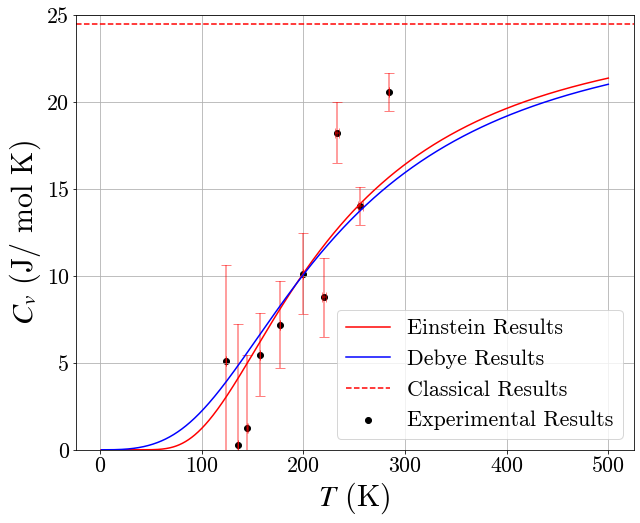

In [84]:
# --- Einstein Results --- 
Temp_s = np.linspace(unp.nominal_values(temp_a).min(), unp.nominal_values(temp_a).max(), 1000)
Temp_s = np.linspace(0, 500, 1000)

# -- model fit 

popt1, pcov1 = curve_fit(heat_capacity_einstein, unp.nominal_values(temp_a), unp.nominal_values(Cu_Cv_exp))

print("Einstein Temperture is then,", popt1[0], '+/-', np.sqrt(pcov1[0][0]))

# --- Debeye Model --- 

popt2, pcov2 = curve_fit(debye, unp.nominal_values(temp_a), unp.nominal_values(Cu_Cv_exp))

print("Debeye Temperture is then,", popt2[0] - 100, '+/-', np.sqrt(pcov2[0][0]))

# --- Scatter Plots --- 

plt.figure(figsize=(10, 8))

plt.scatter(unp.nominal_values(temp_a), unp.nominal_values(Cu_Cv_exp), color = 'black', label = 'Experimental Results')
plt.errorbar(unp.nominal_values(temp_a), unp.nominal_values(Cu_Cv_exp), xerr = unp.std_devs(temp_a), yerr = unp.std_devs(Cu_Cv_exp), capsize= 5, ls='none', color = 'red', alpha = .5)

plt.plot(Temp_s, heat_capacity_einstein(Temp_s,  popt1[0]), color = 'red', label = 'Einstein Results')
plt.plot(Temp_s, debye(Temp_s,  popt2[0]), color = 'blue', label = 'Debye Results')

plt.axhline(y = 24.5, color = 'red', linestyle='--', label = 'Classical Results')
plt.grid()
plt.ylabel("$C_v$ (J/ mol K)")
plt.ylim(0, 25)
plt.xlabel("$T$ (K)")
plt.legend()

plt.savefig('Images/Cu_Experimental_Plot.png', bbox = 'tight')

<ipython-input-19-f497a243da20>:4: RuntimeWarning: divide by zero encountered in true_divide
  term_1 = (et/T)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: divide by zero encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: overflow encountered in square
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-19-f497a243da20>:5: RuntimeWarning: invalid value encountered in true_divide
  term_2 = (np.exp(et/T))/(np.exp(et/T) - 1)**2
<ipython-input-21-14b0d0b484dc>:9: RuntimeWarning: divide by zero encountered in double_scalars
  a  = inte.quad(integrand, 0, D/i)
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: overflow encountered in double_scalars
  return (x**4)*(np.exp(x))/(np.exp(x)-1)**2
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: overflow encountered in exp
  return (x**4)*(np.exp(x))/(np.exp(x)-1)**2
<ipython-input-21-14b0d0b484dc>:2: RuntimeWarning: invalid value encountered in doub

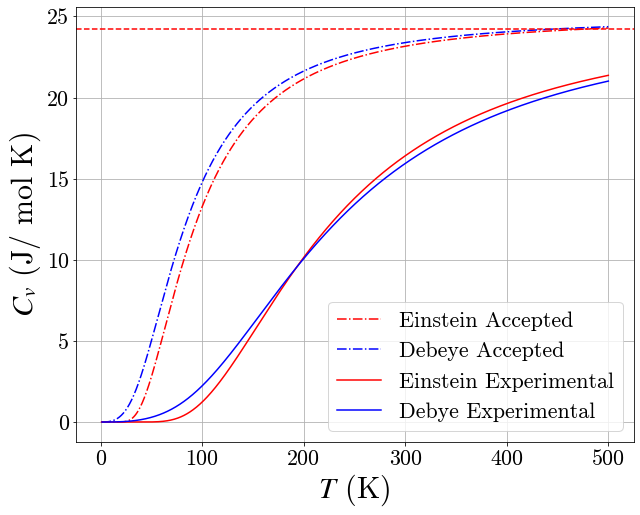

In [85]:
# --- Generating Data for Theortical Models from Derived Equations --- 

# Temp_s = np.linspace(unp.nominal_values(temp_a).min(), unp.nominal_values(temp_a).max(), 1000)
Temp_s = np.linspace(0, 500, 1000)

th_ein = heat_capacity_einstein(Temp_s, 284)
th_Deb = debye(Temp_s, 343)

plt.figure(figsize=(10, 8))

plt.plot(Temp_s, th_ein, color = 'red', label = 'Einstein Accepted', linestyle='dashdot')
plt.plot(Temp_s, th_Deb, color = 'blue', label = 'Debeye Accepted', linestyle='dashdot')
plt.plot(Temp_s, heat_capacity_einstein(Temp_s,  popt1[0]), color = 'red', label = 'Einstein Experimental')
plt.plot(Temp_s, debye(Temp_s,  popt2[0]), color = 'blue', label = 'Debye Experimental')
plt.axhline(y = 24.2, color = 'red', linestyle='--')

plt.grid()

plt.ylabel("$C_v$ (J/ mol K)")
plt.xlabel("$T$ (K)")

plt.legend()

plt.savefig('Images/Cu_Comparison_Plot.png', bbox = 'tight')

$\LaTeX$ and .csv port functions 

In [89]:
def data_frame(T, M, Cv):
    dataframe = pd.DataFrame({'Temp (K)': np.rint(unp.nominal_values(T)), 'UC Temp (K)':  np.round(unp.std_devs(T), 3), 'Mass (g)': np.round(unp.nominal_values(M), 1), 'UC Mass (g)':  np.round(unp.std_devs(M), 3), 'Cv (J/Mol)': np.round(unp.nominal_values(Cv), 0), 'UC Cv (J/Mol)':  np.round(unp.std_devs(Cv), 3) })
    return dataframe

CU_dataframe = data_frame(temp_a, m, Cu_Cv_exp)

CU_dataframe

print(CU_dataframe.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 Temp (K) &  UC Temp (K) &  Mass (g) &  UC Mass (g) &  Cv (J/Mol) &  UC Cv (J/Mol) \\
\midrule
    177.0 &        0.065 &       1.5 &        0.513 &         7.0 &          2.501 \\
    158.0 &        0.064 &       0.9 &        0.393 &         5.0 &          2.376 \\
    145.0 &        0.070 &       0.2 &        0.583 &         1.0 &          4.175 \\
    136.0 &        0.063 &       0.0 &        0.846 &         0.0 &          6.967 \\
    124.0 &        0.057 &       0.5 &        0.539 &         5.0 &          5.555 \\
    256.0 &        2.574 &       5.2 &        0.403 &        14.0 &          1.113 \\
    233.0 &        2.184 &       5.8 &        0.557 &        18.0 &          1.754 \\
    220.0 &        2.150 &       2.6 &        0.665 &         9.0 &          2.265 \\
    200.0 &        0.062 &       2.6 &        0.589 &        10.0 &          2.335 \\
    284.0 &        0.062 &       8.8 &        0.474 &        21.0 &          1.112 \\
\bottomrule


In [87]:
def conv2siunitx(val, err, err_points=4):
    val = f'{val:.20e}'.split('e')
    err = f'{err:.20e}'.split('e') 
    first_uncertain = int(val[1]) - int(err[1]) + err_points

    my_val = f'{np.round(float(val[0]), first_uncertain-1):.10f}'
    my_err = f'{np.round(float(err[0]), err_points-1):.10f}'.replace('.','')
    # Avoid 1. and write 1 instead
    if first_uncertain > 1:
        first_uncertain = first_uncertain + 1

    return(f'{my_val[:first_uncertain]}({my_err[:err_points]})e{val[1]}')

    conv2siunitx(2, 3)

'2.000(3000)e+00'